In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pylab as plt
import math
import seaborn as sbn
%matplotlib inline

## 1. Data Preparation

#### Essential Workers Population Ratio

In [2]:
# dataframe
gdf_ew = gpd.read_file('../../survey_block/data/Taxi_Population/Taxi_Population.shp')

In [3]:
# delete old trip columns
gdf_ew.drop(['trips', 'trips_ly', 'yoy'], axis=1, inplace=True)

In [4]:
# calculate the estimatd essential workers population ratio
gdf_ew['ratio'] = gdf_ew['Essential_'] / gdf_ew['Working Po']

In [5]:
gdf_ew.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,Total Popu,Working Po,Essential_,areaKM2,PopDensity,geometry,ratio
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,NaN,NaN,NaN,7.343,NaN,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",NaN
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,0.0,0.0,0.0,13.370,0.0,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",NaN
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,31097.0,14088.0,6877.0,2.944,10562.8,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",0.488146
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,25076.0,11327.0,2841.0,0.745,33659.1,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",0.250817
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,26887.0,12192.0,4612.0,4.684,5740.2,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",0.378281


#### Subway

In [6]:
gdf_sub = gpd.read_file('../data/subway_updated/SubwayTurnstilesByTaxi_updated.shp')

In [11]:
# calculate entry yoy
gdf_sub['yoy_sub'] = gdf_sub['entries202'] / gdf_sub['entries201'] - 1

In [12]:
gdf_sub.head()

,location_i,borough,shape_area,shape_leng,zone,trips,trips_ly,yoy,entries202,exits2020,entries201,exits2019,pct_change,pct_chan_1,geometry,yoy_sub
0,7.0,Queens,0.000390,0.107417,Astoria,1555.12500,8622.12500,-0.819636,76463.0,83625.0,1331714.0,1165224.0,-1641.644979,-1293.391928,"POLYGON ((-73.90414 40.76752, -73.90325 40.767...",-0.942583
1,14.0,Brooklyn,0.001382,0.175214,Bay Ridge,890.65625,3927.00000,-0.773197,64143.0,64319.0,889547.0,743917.0,-1286.818515,-1056.605358,"POLYGON ((-74.03407 40.64431, -74.03284 40.643...",-0.927893
2,17.0,Brooklyn,0.000323,0.093523,Bedford,1830.06250,7257.40625,-0.747835,97620.0,115884.0,1161782.0,914737.0,-1090.106536,-689.355735,"POLYGON ((-73.94306 40.70142, -73.94220 40.700...",-0.915974
3,18.0,Bronx,0.000149,0.069800,Bedford Park,1418.87500,3585.21875,-0.604243,185818.0,130018.0,1728756.0,948204.0,-830.349051,-629.286714,"POLYGON ((-73.88514 40.86638, -73.88594 40.865...",-0.892513
4,21.0,Brooklyn,0.000380,0.115974,Bensonhurst East,534.65625,1938.65625,-0.724213,100529.0,88753.0,1280564.0,946094.0,-1173.825463,-965.985375,"POLYGON ((-73.97418 40.60946, -73.97403 40.608...",-0.921496


#### Taxi/FHV (pick up base)

In [13]:
# dataframe
gdf_tf = gpd.read_file('../../taxi/results/taxi_fhv/taxi_fhv_yoy.shp')

In [14]:
# rename for taxi/fhv
gdf_tf = gdf_tf.rename(columns={'trips': 'trips_tf', 'trips_ly': 'trips_tf_ly', 'yoy': 'yoy_tf'})

In [15]:
gdf_tf.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,trips_tf,trips_tf_ly,yoy_tf,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,3.142857,80.071429,-0.960749,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,0.285714,0.857143,-0.666667,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,528.357143,1445.000000,-0.634355,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,382.142857,3713.071429,-0.897082,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,40.142857,160.642857,-0.750111,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


#### Aggregate all data

In [16]:
# base from essential worker dataframe
col_ew = ['borough', 'location_i', 'objectid', 'shape_area', 'shape_leng', 'zone', 'geometry', 'ratio']
gdf_tz = gdf_ew[col_ew].copy()

In [19]:
# merge with subway data
gdf_tz = gdf_tz.merge(gdf_sub[['location_i', 'yoy_sub']], left_on='location_i', right_on='location_i', how='left')

In [20]:
# merge with taxi/fhv data
gdf_tz = gdf_tz.merge(gdf_tf[['location_i', 'yoy_tf']], left_on='location_i', right_on='location_i', how='left')

In [21]:
# final table
gdf_tz

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,ratio,yoy_sub,yoy_tf
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",NaN,NaN,-0.960749
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",NaN,NaN,-0.666667
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",0.488146,NaN,-0.634355
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",0.250817,NaN,-0.897082
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",0.378281,NaN,-0.750111
...,...,...,...,...,...,...,...,...,...,...
257,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712...",0.256672,-0.939301,-0.901175
258,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",0.487212,-0.873806,-0.595934
259,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",0.469083,-0.932081,-0.831883
260,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",0.129051,-0.962322,-0.951352


## 2. Visualization

Text(0.5, 1.0, '# of Pickup YoY: Taxi and FHV')

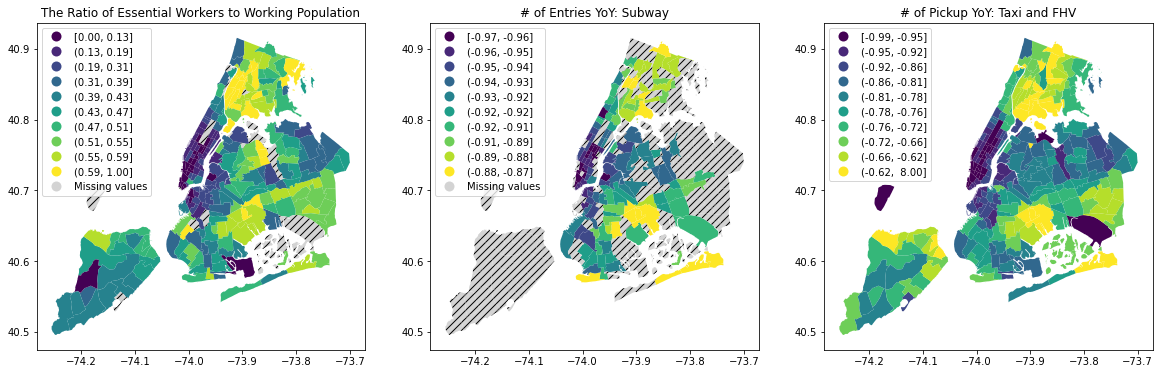

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))

gdf_tz.plot(ax=axes[0], column='ratio', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'}, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                # "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"})

gdf_tz.plot(ax=axes[1], column='yoy_sub', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'}, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                # "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"})

gdf_tz.plot(ax=axes[2], column='yoy_tf', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

axes[0].set_title('The Ratio of Essential Workers to Working Population')
axes[1].set_title('# of Entries YoY: Subway')
axes[2].set_title('# of Pickup YoY: Taxi and FHV')

## 3. Regression Analysis (drop NA)

### 3-1. Subway + Taxi/FHV

In [23]:
data_all = gdf_tz[['location_i', 'ratio', 'yoy_sub', 'yoy_tf']]
data_all = data_all.dropna()

In [24]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     230.3
Date:                Tue, 04 May 2021   Prob (F-statistic):           9.77e-46
Time:                        21:42:06   Log-Likelihood:                 150.91
No. Observations:                 148   AIC:                            -295.8
Df Residuals:                     145   BIC:                            -286.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1868      0.521      4.195      0.0

### 3-2. Subway

In [25]:
data_sub = gdf_tz[['location_i', 'ratio', 'yoy_sub']]
data_sub = data_sub.dropna()

In [26]:
lm = smf.ols(formula='ratio~yoy_sub', data = data_sub).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     315.2
Date:                Tue, 04 May 2021   Prob (F-statistic):           2.70e-38
Time:                        21:42:09   Log-Likelihood:                 130.25
No. Observations:                 148   AIC:                            -256.5
Df Residuals:                     146   BIC:                            -250.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3341      0.280     19.059      0.0

### 3-3 Taxi/FHV

In [27]:
data_tf = gdf_tz[['location_i', 'ratio', 'yoy_tf']]
data_tf = data_tf.dropna()

In [28]:
lm = smf.ols(formula='ratio~yoy_tf', data = data_tf).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     429.7
Date:                Tue, 04 May 2021   Prob (F-statistic):           1.19e-55
Time:                        21:42:12   Log-Likelihood:                 203.14
No. Observations:                 245   AIC:                            -402.3
Df Residuals:                     243   BIC:                            -395.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3420      0.046     28.997      0.0

### 3-4. Polynomial Regression

2nd polynomial regression performs the best.

In [29]:
data_all['yoy_sub2'] = data_all['yoy_sub'].apply(lambda x: x**2)
data_all['yoy_tf2'] = data_all['yoy_tf'].apply(lambda x: x**2)
data_all['yoy_sub3'] = data_all['yoy_sub'].apply(lambda x: x**3)
data_all['yoy_tf3'] = data_all['yoy_tf'].apply(lambda x: x**3)
data_all['yoy_sub4'] = data_all['yoy_sub'].apply(lambda x: x**4)
data_all['yoy_tf4'] = data_all['yoy_tf'].apply(lambda x: x**4)

In [30]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     136.9
Date:                Tue, 04 May 2021   Prob (F-statistic):           7.18e-48
Time:                        21:42:14   Log-Likelihood:                 161.67
No. Observations:                 148   AIC:                            -313.3
Df Residuals:                     143   BIC:                            -298.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6974     11.372     -0.061      0.9

In [31]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2+yoy_sub3+yoy_tf3', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     91.79
Date:                Tue, 04 May 2021   Prob (F-statistic):           3.33e-46
Time:                        21:42:16   Log-Likelihood:                 162.82
No. Observations:                 148   AIC:                            -311.6
Df Residuals:                     141   BIC:                            -290.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -455.1209    323.862     -1.405      0.1

In [32]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2+yoy_sub3+yoy_tf3+yoy_sub4+yoy_tf4', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     69.00
Date:                Tue, 04 May 2021   Prob (F-statistic):           1.24e-44
Time:                        21:42:18   Log-Likelihood:                 163.80
No. Observations:                 148   AIC:                            -309.6
Df Residuals:                     139   BIC:                            -282.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    565.5651   1.04e+04      0.055      0.9

## 4. Regression Analysis (with dummy variables)

In [33]:
# prepare a new dataframe
data_na = gdf_tz[['location_i', 'ratio', 'yoy_sub', 'yoy_tf']].copy()

In [34]:
# flag for missing values
data_na['yoy_sub_na'] = 1 * data_na['yoy_sub'].isnull()
# data_na['yoy_tf_na'] = 1 * data_na['yoy_tf'].isnull()

In [35]:
# fill missing values with mean
data_na['yoy_sub'] = data_na['yoy_sub'].fillna(data_na['yoy_sub'].mean()) 
# data_na['yoy_tf'] = data_na['yoy_tf'].fillna(data_na['yoy_tf'].mean()) 

In [36]:
# create 2nd polynomial
data_na['yoy_sub2'] = data_na['yoy_sub'].apply(lambda x: x**2)
data_na['yoy_tf2'] = data_na['yoy_tf'].apply(lambda x: x**2)

In [37]:
data_na

,location_i,ratio,yoy_sub,yoy_tf,yoy_sub_na,yoy_sub2,yoy_tf2
0,1.0,NaN,-0.923543,-0.960749,1,0.852931,0.923039
1,2.0,NaN,-0.923543,-0.666667,1,0.852931,0.444444
2,3.0,0.488146,-0.923543,-0.634355,1,0.852931,0.402406
3,4.0,0.250817,-0.923543,-0.897082,1,0.852931,0.804756
4,5.0,0.378281,-0.923543,-0.750111,1,0.852931,0.562667
...,...,...,...,...,...,...,...
257,256.0,0.256672,-0.939301,-0.901175,0,0.882287,0.812116
258,259.0,0.487212,-0.873806,-0.595934,0,0.763537,0.355138
259,260.0,0.469083,-0.932081,-0.831883,0,0.868775,0.692030
260,261.0,0.129051,-0.962322,-0.951352,0,0.926064,0.905071


In [38]:
# drop rows which ration is missing
data_na = data_na.dropna()

In [39]:
data_na

,location_i,ratio,yoy_sub,yoy_tf,yoy_sub_na,yoy_sub2,yoy_tf2
2,3.0,0.488146,-0.923543,-0.634355,1,0.852931,0.402406
3,4.0,0.250817,-0.923543,-0.897082,1,0.852931,0.804756
4,5.0,0.378281,-0.923543,-0.750111,1,0.852931,0.562667
5,6.0,0.443022,-0.923543,-0.669439,1,0.852931,0.448149
6,7.0,0.323658,-0.942583,-0.850706,0,0.888463,0.723700
...,...,...,...,...,...,...,...
257,256.0,0.256672,-0.939301,-0.901175,0,0.882287,0.812116
258,259.0,0.487212,-0.873806,-0.595934,0,0.763537,0.355138
259,260.0,0.469083,-0.932081,-0.831883,0,0.868775,0.692030
260,261.0,0.129051,-0.962322,-0.951352,0,0.926064,0.905071


In [40]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub_na', data = data_na).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     150.0
Date:                Tue, 04 May 2021   Prob (F-statistic):           7.68e-55
Time:                        21:42:26   Log-Likelihood:                 207.42
No. Observations:                 245   AIC:                            -406.8
Df Residuals:                     241   BIC:                            -392.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0906      0.404      5.179      0.0

In [41]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2+yoy_sub_na', data = data_na).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     107.2
Date:                Tue, 04 May 2021   Prob (F-statistic):           5.21e-59
Time:                        21:42:28   Log-Likelihood:                 222.49
No. Observations:                 245   AIC:                            -433.0
Df Residuals:                     239   BIC:                            -412.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1991     11.841      0.692      0.4

## 5. Output Prediction

In [42]:
# best model
lm_best = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2+yoy_sub_na', data = data_na).fit()
print(lm_best.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     107.2
Date:                Tue, 04 May 2021   Prob (F-statistic):           5.21e-59
Time:                        21:42:30   Log-Likelihood:                 222.49
No. Observations:                 245   AIC:                            -433.0
Df Residuals:                     239   BIC:                            -412.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1991     11.841      0.692      0.4

In [43]:
data_pred = data_na.copy()
data_pred['pred_ratio'] = lm_best.predict(data_na)

In [44]:
result = gdf_tz.merge(data_pred[['location_i', 'pred_ratio']], left_on='location_i', right_on='location_i', how='left')

In [45]:
result = result.merge(gdf_ew[['location_i', 'Total Popu', 'Working Po', 'Essential_']], left_on='location_i', right_on='location_i', how='left')

In [46]:
result['pred_essential'] = result['Working Po'] * result['pred_ratio']

In [47]:
result = result.rename(columns={'ratio': 'census_ratio', 'Total Popu': 'census_total', 'Working Po': 'census_working', 'Essential_': 'census_essential'})

Text(0.5, 1.0, 'Prediction')

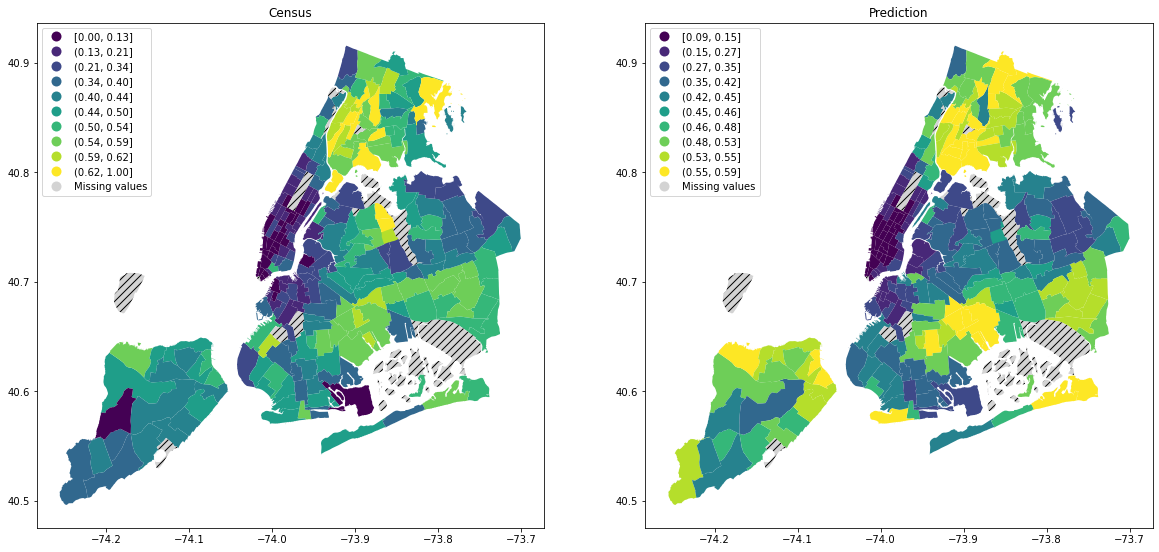

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

result.plot(ax=axes[0], column='census_ratio', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'}, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                # "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"})

result.plot(ax=axes[1], column='pred_ratio', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'}, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                # "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"})

axes[0].set_title('Census')
axes[1].set_title('Prediction')

In [49]:
data_pred

,location_i,ratio,yoy_sub,yoy_tf,yoy_sub_na,yoy_sub2,yoy_tf2,pred_ratio
2,3.0,0.488146,-0.923543,-0.634355,1,0.852931,0.402406,0.546330
3,4.0,0.250817,-0.923543,-0.897082,1,0.852931,0.804756,0.269538
4,5.0,0.378281,-0.923543,-0.750111,1,0.852931,0.562667,0.475357
5,6.0,0.443022,-0.923543,-0.669439,1,0.852931,0.448149,0.533300
6,7.0,0.323658,-0.942583,-0.850706,0,0.888463,0.723700,0.318273
...,...,...,...,...,...,...,...,...
257,256.0,0.256672,-0.939301,-0.901175,0,0.882287,0.812116,0.232504
258,259.0,0.487212,-0.873806,-0.595934,0,0.763537,0.355138,0.580764
259,260.0,0.469083,-0.932081,-0.831883,0,0.868775,0.692030,0.349730
260,261.0,0.129051,-0.962322,-0.951352,0,0.926064,0.905071,0.130527


In [50]:
result[result['location_i']==30]

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,census_ratio,yoy_sub,yoy_tf,pred_ratio,census_total,census_working,census_essential,pred_essential
32,Queens,30.0,30.0,0.000146,0.09451,Broad Channel,"POLYGON ((-73.82076 40.61523, -73.81769 40.614...",0.51227,-0.907026,-0.713355,0.495464,2320.0,978.0,501.0,484.563499


In [416]:
result.to_file('../results/regression/model_output.shp')